In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification, pipeline
from sklearn.metrics import confusion_matrix, classification_report
from peft import LoraConfig, TaskType, get_peft_model
from datasets import Dataset
import plotly.graph_objects as go
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import evaluate
import torch
import json
import re

In [2]:
def process_jsonl(input_file, tokenizer, sentiment_mapping):
    def clean_word(word):
        return word.strip()

    def split_text_into_tokens(text):
        return re.findall(r'\w+|[^\w\s]', text, re.UNICODE)

    with open(input_file, 'r', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]

    processed_data = []

    for item in data:
        text = item['text']
        labels = item.get('label', [])  # Use .get() to handle missing 'label' fields

        tokens = split_text_into_tokens(text)
        token_offsets = []
        current_pos = 0

        for token in tokens:
            start = text.find(token, current_pos)
            end = start + len(token)
            token_offsets.append((start, end))
            current_pos = end

        token_labels = ["O"] * len(tokens)

        for start, end, sentiment in labels:
            sentiment_standard = sentiment_mapping.get(sentiment, "O")
            if sentiment_standard == "O":
                continue

            for i, (token_start, token_end) in enumerate(token_offsets):
                if token_start >= start and token_end <= end:
                    if token_start == start:
                        token_labels[i] = f"B-{sentiment_standard}"
                    else:
                        token_labels[i] = f"I-{sentiment_standard}"

        cleaned_tokens = [clean_word(token) for token in tokens]
        cleaned_tokens, token_labels = zip(*[
            (token, label) for token, label in zip(cleaned_tokens, token_labels) if token
        ])

        processed_data.append({
            "tokens": list(cleaned_tokens),
            "labels": list(token_labels)
        })

    return processed_data


tokenizer = AutoTokenizer.from_pretrained(
    "sdadas/polish-gpt2-medium", use_fast=True, add_prefix_space=True
)
tokenizer.pad_token = tokenizer.eos_token
sentiment_mapping = {
    'Negative': 'Negative',
    'Neutral': 'Neutral',
    'Positive': 'Positive'
}
processed_data = process_jsonl("patryk.jsonl", tokenizer, sentiment_mapping)




In [3]:
dataset = Dataset.from_pandas(pd.DataFrame(processed_data))
print("Dataset example:")
print(dataset[0])

Dataset example:
{'tokens': ['Lakier', 'roweru', 'bardzo', 'kiepskiej', 'jakości', ',', 'robią', 'się', 'odpryski', 'nie', 'wiadomo', 'od', 'czego', 'rower', 'ładny', 'wygodny', 'ale', 'po', '3', 'miesiącach', 'użytkowania', 'widoczne', 'odpryski', 'lakieru', 'czego', 'za', 'taką', 'cenę', 'nie', 'powinno', 'być', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', 'Oczywiście', 'producent', 'twierdzi', 'że', 'są', 'to', 'wady', 'mechaniczne', ',', 'dziecko', 'ma', 'w', 'lepszym', 'stanie', 'lakier', 'na', 'rowerze', 'ale', 'nie', 'z', 'tej', 'firmy', 'ODRADZAM', 'ZAKUP', 'Z', 'TEGO', 'POWODU', 'SZKODA', 'TYLE', 'KASY', 'I', 'NERWÓW', 'chyba', 'ze', 'rower', 'będzie', 'stał', 'nieużywany', 'za', 'szybą', '.', 'Na', 'zakończenie', 'powiem', 'tak', 'porównując', 'lakier', 'zwykły', 'do', 'paznokci', 'a', 'hybrydę', 'wiadomo', 'w', 'tańszym', 'zwykłym', 'lakierze', 'robią', 'się', 'odpryski', 'a', 'lepszym', 'nie', '!', '!', '!', '!', '

In [4]:
label_list = ["O", "B-Negative", "I-Negative", "B-Positive", "I-Positive", "B-Neutral", "I-Neutral"]

label_to_id = {label: idx for idx, label in enumerate(label_list)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

print("Label to ID Mapping:")
print(label_to_id)

print("\nID to Label Mapping:")
print(id_to_label)

Label to ID Mapping:
{'O': 0, 'B-Negative': 1, 'I-Negative': 2, 'B-Positive': 3, 'I-Positive': 4, 'B-Neutral': 5, 'I-Neutral': 6}

ID to Label Mapping:
{0: 'O', 1: 'B-Negative', 2: 'I-Negative', 3: 'B-Positive', 4: 'I-Positive', 5: 'B-Neutral', 6: 'I-Neutral'}


In [5]:
def tokenize_and_align_labels(examples):
    """
    Tokenizes the input texts and aligns the labels with the tokens.
    
    Args:
        examples (dict): Dictionary containing 'tokens' and 'labels'.
        
    Returns:
        dict: Tokenized inputs with aligned labels.
    """
    tokenized_inputs = tokenizer(
        examples['tokens'],
        is_split_into_words=True,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_offsets_mapping=True
    )
    
    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to words
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Special tokens
            elif word_idx != previous_word_idx:
                label_ids.append(label_to_id.get(label[word_idx], 0))
            else:
                if label[word_idx].startswith("B-"):
                    label_ids.append(label_to_id.get(label[word_idx].replace("B-", "I-"), 0))
                else:
                    label_ids.append(label_to_id.get(label[word_idx], 0))
            previous_word_idx = word_idx
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=['tokens', 'labels']
)

print("Tokenized Dataset Example:")
print(tokenized_datasets[0])

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Tokenized Dataset Example:
{'labels': [0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0], 'input_ids': [573, 301, 523, 29345, 702, 11265, 775, 5059, 2402, 5166, 309, 672, 368, 452, 304, 3151, 357, 1386, 5557, 24161, 31670, 478, 291, 719, 10542, 15268, 13048, 672, 368, 452, 46987, 383, 1386, 313, 2594, 6908, 304, 3438, 739, 13731, 13731, 13731, 13731, 13731, 13731, 13731, 13731, 13731, 13731, 13731, 13731, 13731, 13731, 13731, 13731, 13731, 13731, 13731, 13731, 13731, 7083, 15271, 6905, 337, 543, 339, 18822, 42797, 2402, 2846, 438, 264, 16163, 1619, 25509, 293, 22660, 478, 304, 268, 725, 3390, 18373, 4069, 3454, 6300, 556, 6197, 57, 52, 556, 14652, 8076, 4493

In [6]:
tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.2, seed=42)

train_dataset = tokenized_datasets['train']
eval_dataset = tokenized_datasets['test']

print(f"\nNumber of training samples: {len(train_dataset)}")
print(f"Number of evaluation samples: {len(eval_dataset)}")


Number of training samples: 240
Number of evaluation samples: 60


In [7]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [8]:
foundation_model = AutoModelForTokenClassification.from_pretrained(
    "sdadas/polish-gpt2-medium",
    num_labels=len(label_list),
    id2label=id_to_label,
    label2id=label_to_id
)
foundation_model

Some weights of GPT2ForTokenClassification were not initialized from the model checkpoint at sdadas/polish-gpt2-medium and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForTokenClassification(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): FastGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(in_features=1024, out_features=7

In [9]:
for name, module in foundation_model.named_modules():
    print(name)


transformer
transformer.wte
transformer.wpe
transformer.drop
transformer.h
transformer.h.0
transformer.h.0.ln_1
transformer.h.0.attn
transformer.h.0.attn.c_attn
transformer.h.0.attn.c_proj
transformer.h.0.attn.attn_dropout
transformer.h.0.attn.resid_dropout
transformer.h.0.ln_2
transformer.h.0.mlp
transformer.h.0.mlp.c_fc
transformer.h.0.mlp.c_proj
transformer.h.0.mlp.act
transformer.h.0.mlp.dropout
transformer.h.1
transformer.h.1.ln_1
transformer.h.1.attn
transformer.h.1.attn.c_attn
transformer.h.1.attn.c_proj
transformer.h.1.attn.attn_dropout
transformer.h.1.attn.resid_dropout
transformer.h.1.ln_2
transformer.h.1.mlp
transformer.h.1.mlp.c_fc
transformer.h.1.mlp.c_proj
transformer.h.1.mlp.act
transformer.h.1.mlp.dropout
transformer.h.2
transformer.h.2.ln_1
transformer.h.2.attn
transformer.h.2.attn.c_attn
transformer.h.2.attn.c_proj
transformer.h.2.attn.attn_dropout
transformer.h.2.attn.resid_dropout
transformer.h.2.ln_2
transformer.h.2.mlp
transformer.h.2.mlp.c_fc
transformer.h.2.mlp

In [10]:

print(list(TaskType))

lora_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS,          # Correct task type for token-level tasks
    r=64,                                  # Rank of LoRA; adjust as needed
    lora_alpha=32,                         # Scaling factor; adjust as needed
    lora_dropout=0.05,                     # Dropout probability
    # target_modules=["classifier"]           # Correct target module(s)
)

[<TaskType.SEQ_CLS: 'SEQ_CLS'>, <TaskType.SEQ_2_SEQ_LM: 'SEQ_2_SEQ_LM'>, <TaskType.CAUSAL_LM: 'CAUSAL_LM'>, <TaskType.TOKEN_CLS: 'TOKEN_CLS'>, <TaskType.QUESTION_ANS: 'QUESTION_ANS'>, <TaskType.FEATURE_EXTRACTION: 'FEATURE_EXTRACTION'>]


In [11]:
peft_model = get_peft_model(foundation_model, lora_config)
peft_model.print_trainable_parameters()

trainable params: 6,298,631 || all params: 363,143,182 || trainable%: 1.7345


/opt/miniconda3/envs/py310/lib/python3.10/site-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [12]:
peft_model.config.id2label = id_to_label
peft_model.config.label2id = label_to_id
print("Model config id_to_label:", peft_model.config.id2label)
print("Model config label2id:", peft_model.config.label2id)

Model config id_to_label: {0: 'O', 1: 'B-Negative', 2: 'I-Negative', 3: 'B-Positive', 4: 'I-Positive', 5: 'B-Neutral', 6: 'I-Neutral'}
Model config label2id: {'O': 0, 'B-Negative': 1, 'I-Negative': 2, 'B-Positive': 3, 'I-Positive': 4, 'B-Neutral': 5, 'I-Neutral': 6}


In [13]:
peft_model

PeftModelForTokenClassification(
  (base_model): LoraModel(
    (model): GPT2ForTokenClassification(
      (transformer): GPT2Model(
        (wte): Embedding(51200, 1024)
        (wpe): Embedding(2048, 1024)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-23): 24 x GPT2Block(
            (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2SdpaAttention(
              (c_attn): lora.Linear(
                (base_layer): Conv1D(nf=3072, nx=1024)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embeddi

In [ ]:
metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels_all = [
        [id_to_label[label] for label in label_seq if label != -100]
        for label_seq in labels
    ]
    true_predictions_all = [
        [id_to_label[pred] for (pred, label) in zip(pred_seq, label_seq) if label != -100]
        for pred_seq, label_seq in zip(predictions, labels)
    ]

    results_all = metric.compute(predictions=true_predictions_all, references=true_labels_all)

    true_labels_without_O = [
        [id_to_label[label] for label in label_seq if label != -100 and id_to_label[label] != "O"]
        for label_seq in labels
    ]
    true_predictions_without_O = [
        [id_to_label[pred] for (pred, label) in zip(pred_seq, label_seq) if label != -100 and id_to_label[label] != "O"]
        for pred_seq, label_seq in zip(predictions, labels)
    ]

    results_without_O = metric.compute(predictions=true_predictions_without_O, references=true_labels_without_O)
    
    return {
        "precision_all": results_all.get("overall_precision", 0.0),
        "recall_all": results_all.get("overall_recall", 0.0),
        "f1_all": results_all.get("overall_f1", 0.0),
        "accuracy_all": results_all.get("overall_accuracy", 0.0),
        "precision_without_O": results_without_O.get("overall_precision", 0.0),
        "recall_without_O": results_without_O.get("overall_recall", 0.0),
        "f1_without_O": results_without_O.get("overall_f1", 0.0),
        "accuracy_without_O": results_without_O.get("overall_accuracy", 0.0),
    }


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_all",
    greater_is_better=True,
)

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

results = trainer.evaluate()
print("\nEvaluation Results:")
print(results)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/150 [00:00<?, ?it/s]

{'loss': 2.0083, 'grad_norm': 15.691094398498535, 'learning_rate': 1.866666666666667e-05, 'epoch': 0.67}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 1.7051337957382202, 'eval_precision_all': 0.005759539236861051, 'eval_recall_all': 0.0625, 'eval_f1_all': 0.01054713249835201, 'eval_accuracy_all': 0.3451834862385321, 'eval_precision_without_O': 0.10891089108910891, 'eval_recall_without_O': 0.0859375, 'eval_f1_without_O': 0.09606986899563319, 'eval_accuracy_without_O': 0.09615384615384616, 'eval_runtime': 2.4627, 'eval_samples_per_second': 24.363, 'eval_steps_per_second': 1.624, 'epoch': 1.0}
{'loss': 1.7663, 'grad_norm': 14.935571670532227, 'learning_rate': 1.7333333333333336e-05, 'epoch': 1.33}
{'loss': 1.4435, 'grad_norm': 12.815917015075684, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 1.3012654781341553, 'eval_precision_all': 0.007947019867549669, 'eval_recall_all': 0.046875, 'eval_f1_all': 0.013590033975084936, 'eval_accuracy_all': 0.6257645259938838, 'eval_precision_without_O': 0.11475409836065574, 'eval_recall_without_O': 0.0546875, 'eval_f1_without_O': 0.07407407407407407, 'eval_accuracy_without_O': 0.07211538461538461, 'eval_runtime': 2.2894, 'eval_samples_per_second': 26.208, 'eval_steps_per_second': 1.747, 'epoch': 2.0}
{'loss': 1.212, 'grad_norm': 11.809962272644043, 'learning_rate': 1.4666666666666666e-05, 'epoch': 2.67}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.9796135425567627, 'eval_precision_all': 0.009287925696594427, 'eval_recall_all': 0.0234375, 'eval_f1_all': 0.013303769401330379, 'eval_accuracy_all': 0.801605504587156, 'eval_precision_without_O': 0.13793103448275862, 'eval_recall_without_O': 0.03125, 'eval_f1_without_O': 0.050955414012738856, 'eval_accuracy_without_O': 0.038461538461538464, 'eval_runtime': 2.2302, 'eval_samples_per_second': 26.904, 'eval_steps_per_second': 1.794, 'epoch': 3.0}
{'loss': 1.0112, 'grad_norm': 7.762357234954834, 'learning_rate': 1.3333333333333333e-05, 'epoch': 3.33}
{'loss': 0.8223, 'grad_norm': 7.904035568237305, 'learning_rate': 1.2e-05, 'epoch': 4.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.7459805607795715, 'eval_precision_all': 0.0, 'eval_recall_all': 0.0, 'eval_f1_all': 0.0, 'eval_accuracy_all': 0.886085626911315, 'eval_precision_without_O': 0.0, 'eval_recall_without_O': 0.0, 'eval_f1_without_O': 0.0, 'eval_accuracy_without_O': 0.014423076923076924, 'eval_runtime': 2.2047, 'eval_samples_per_second': 27.215, 'eval_steps_per_second': 1.814, 'epoch': 4.0}
{'loss': 0.6874, 'grad_norm': 5.7533345222473145, 'learning_rate': 1.0666666666666667e-05, 'epoch': 4.67}


  0%|          | 0/4 [00:00<?, ?it/s]

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.5962017774581909, 'eval_precision_all': 0.0, 'eval_recall_all': 0.0, 'eval_f1_all': 0.0, 'eval_accuracy_all': 0.9063455657492355, 'eval_precision_without_O': 0.0, 'eval_recall_without_O': 0.0, 'eval_f1_without_O': 0.0, 'eval_accuracy_without_O': 0.0, 'eval_runtime': 2.2179, 'eval_samples_per_second': 27.052, 'eval_steps_per_second': 1.803, 'epoch': 5.0}
{'loss': 0.5844, 'grad_norm': 3.5795679092407227, 'learning_rate': 9.333333333333334e-06, 'epoch': 5.33}
{'loss': 0.5313, 'grad_norm': 3.6873679161071777, 'learning_rate': 8.000000000000001e-06, 'epoch': 6.0}


  0%|          | 0/4 [00:00<?, ?it/s]

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.5133211016654968, 'eval_precision_all': 0.0, 'eval_recall_all': 0.0, 'eval_f1_all': 0.0, 'eval_accuracy_all': 0.9151376146788991, 'eval_precision_without_O': 0.0, 'eval_recall_without_O': 0.0, 'eval_f1_without_O': 0.0, 'eval_accuracy_without_O': 0.0, 'eval_runtime': 2.1873, 'eval_samples_per_second': 27.431, 'eval_steps_per_second': 1.829, 'epoch': 6.0}
{'loss': 0.472, 'grad_norm': 3.0079524517059326, 'learning_rate': 6.666666666666667e-06, 'epoch': 6.67}


  0%|          | 0/4 [00:00<?, ?it/s]

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.4739460051059723, 'eval_precision_all': 0.0, 'eval_recall_all': 0.0, 'eval_f1_all': 0.0, 'eval_accuracy_all': 0.9181957186544343, 'eval_precision_without_O': 0.0, 'eval_recall_without_O': 0.0, 'eval_f1_without_O': 0.0, 'eval_accuracy_without_O': 0.0, 'eval_runtime': 2.2343, 'eval_samples_per_second': 26.854, 'eval_steps_per_second': 1.79, 'epoch': 7.0}
{'loss': 0.4871, 'grad_norm': 2.435640573501587, 'learning_rate': 5.333333333333334e-06, 'epoch': 7.33}
{'loss': 0.4449, 'grad_norm': 1.142958164215088, 'learning_rate': 4.000000000000001e-06, 'epoch': 8.0}


  0%|          | 0/4 [00:00<?, ?it/s]

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.45755401253700256, 'eval_precision_all': 0.0, 'eval_recall_all': 0.0, 'eval_f1_all': 0.0, 'eval_accuracy_all': 0.9181957186544343, 'eval_precision_without_O': 0.0, 'eval_recall_without_O': 0.0, 'eval_f1_without_O': 0.0, 'eval_accuracy_without_O': 0.0, 'eval_runtime': 2.2281, 'eval_samples_per_second': 26.929, 'eval_steps_per_second': 1.795, 'epoch': 8.0}
{'loss': 0.4229, 'grad_norm': 1.7102385759353638, 'learning_rate': 2.666666666666667e-06, 'epoch': 8.67}


  0%|          | 0/4 [00:00<?, ?it/s]

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.4511711001396179, 'eval_precision_all': 0.0, 'eval_recall_all': 0.0, 'eval_f1_all': 0.0, 'eval_accuracy_all': 0.918960244648318, 'eval_precision_without_O': 0.0, 'eval_recall_without_O': 0.0, 'eval_f1_without_O': 0.0, 'eval_accuracy_without_O': 0.0, 'eval_runtime': 2.2594, 'eval_samples_per_second': 26.556, 'eval_steps_per_second': 1.77, 'epoch': 9.0}
{'loss': 0.4226, 'grad_norm': 1.3819661140441895, 'learning_rate': 1.3333333333333334e-06, 'epoch': 9.33}
{'loss': 0.4366, 'grad_norm': 1.094304084777832, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/4 [00:00<?, ?it/s]

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.44942706823349, 'eval_precision_all': 0.0, 'eval_recall_all': 0.0, 'eval_f1_all': 0.0, 'eval_accuracy_all': 0.9193425076452599, 'eval_precision_without_O': 0.0, 'eval_recall_without_O': 0.0, 'eval_f1_without_O': 0.0, 'eval_accuracy_without_O': 0.0, 'eval_runtime': 2.2641, 'eval_samples_per_second': 26.5, 'eval_steps_per_second': 1.767, 'epoch': 10.0}
{'train_runtime': 329.2961, 'train_samples_per_second': 7.288, 'train_steps_per_second': 0.456, 'train_loss': 0.850186440149943, 'epoch': 10.0}


  0%|          | 0/4 [00:00<?, ?it/s]


Evaluation Results:
{'eval_loss': 1.3012654781341553, 'eval_precision_all': 0.007947019867549669, 'eval_recall_all': 0.046875, 'eval_f1_all': 0.013590033975084936, 'eval_accuracy_all': 0.6257645259938838, 'eval_precision_without_O': 0.11475409836065574, 'eval_recall_without_O': 0.0546875, 'eval_f1_without_O': 0.07407407407407407, 'eval_accuracy_without_O': 0.07211538461538461, 'eval_runtime': 2.4077, 'eval_samples_per_second': 24.92, 'eval_steps_per_second': 1.661, 'epoch': 10.0}


In [16]:
results = trainer.evaluate()
print("\nEvaluation Results:")
print(results)

  0%|          | 0/4 [00:00<?, ?it/s]


Evaluation Results:
{'eval_loss': 1.3012654781341553, 'eval_precision_all': 0.007947019867549669, 'eval_recall_all': 0.046875, 'eval_f1_all': 0.013590033975084936, 'eval_accuracy_all': 0.6257645259938838, 'eval_precision_without_O': 0.11475409836065574, 'eval_recall_without_O': 0.0546875, 'eval_f1_without_O': 0.07407407407407407, 'eval_accuracy_without_O': 0.07211538461538461, 'eval_runtime': 2.1905, 'eval_samples_per_second': 27.391, 'eval_steps_per_second': 1.826, 'epoch': 10.0}


In [17]:
sentiment_colors = {
    'Negative': 'red',
    'Neutral': 'gray',
    'Positive': 'green'
}


In [18]:
def get_sentiment(label):
    """Extract the base sentiment from the label."""
    if label.startswith('B-') or label.startswith('I-'):
        return label.split('-', 1)[1]
    return label

In [19]:
nlp = pipeline(
    "token-classification",
    model=peft_model,
    tokenizer=tokenizer,
    aggregation_strategy="simple"  # Try 'none' if 'simple' does not work
)

inference_results = []

example_texts = [
    "Nie jestem zadowolony z zakupu. Słuchawki są niewygodne i głośność jest irytująca.",
    "Film był niezwykle fascynujący, ale zakończenie pozostawiło mnie rozczarowanego.",
    "Nowy telefon ma świetny design i imponującą baterię, jednak kamera jest słaba.",
    "Jestem bardzo zadowolony z obsługi klienta; pracownicy byli uprzejmi i pomocni.",
    "Produkt okazał się bezużyteczny i niskiej jakości, co mnie bardzo zdenerwowało.",
    "Restauracja oferuje wyśmienite jedzenie, ale atmosfera jest zbyt głośna.",
    "Książka była inspirująca i pełna ciekawych pomysłów, jednak tempo narracji było zbyt wolne.",
    "Samochód jest niezawodny i komfortowy, ale zużycie paliwa jest wysokie.",
    "Prezentacja była dobrze przygotowana i klarowna, jednak brakuje jej interakcji z publicznością.",
    "Mieszkanie jest przestronne i nowoczesne, jednak lokalizacja nie jest dogodna.",
    "Ubrania w tym sklepie są stylowe i wygodne, ale ceny są zbyt wysokie."
]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
The model 'PeftModelForTokenClassification' is not supported for token-classification. Supported models are ['AlbertForTokenClassification', 'BertForTokenClassification', 'BigBirdForTokenClassification', 'BioGptForTokenClassification', 'BloomForTokenClassification', 'BrosForTokenClassification', 'CamembertForTokenClassification', 'CanineForTokenClassification', 'ConvBertForTokenClassification', 'Data2VecTextForTokenClassification', 'DebertaForTokenClassification', 'DebertaV2ForTokenClassification', 'DistilBertForTokenClassification', 'ElectraForTokenClassification', 'ErnieForTokenClassification', 'ErnieMForTokenClassification', 'EsmForTokenClassification', 'FalconForTokenClassification', 'FlaubertForTokenClassification', 'FNetForTokenClassification', 'FunnelForTokenClassification', 'GemmaForTokenClassification', 'Gemma2ForTokenClassification'

In [20]:
for text in example_texts:
    predictions = nlp(text)
    inference_results.append({
        "text": text,
        "predictions": predictions
    })
    print(f"\nText: {text}")
    print("Inference Results:")
    print(predictions)

    # For debugging: print first prediction's keys
    if predictions:
        print("Keys in prediction:", predictions[0].keys())

    # Proceed to handle predictions
    words = text.split()
    
    sentiments = []
    scores = []
    
    word_sentiments = ['O'] * len(words)
    word_scores = [0.0] * len(words)
    
    for pred in predictions:
        # Use .get() to safely access keys
        label = pred.get('entity') or pred.get('entity_group')
        if label is None:
            print("Missing 'entity' and 'entity_group' in prediction:", pred)
            continue
        sentiment = get_sentiment(label)
        score = pred.get('score', 0.0)
        word = pred.get('word', '').replace('</w>', '').strip()
        
        for idx, w in enumerate(words):
            clean_w = re.sub(r'[^\w]', '', w)
            if word.lower() == clean_w.lower():
                word_sentiments[idx] = sentiment
                word_scores[idx] = score
                break
    
    colors = [sentiment_colors.get(sentiment, 'black') for sentiment in word_sentiments]
    
    hover_texts = [f"Sentiment: {sentiment}<br>Score: {score:.2f}" 
                   for sentiment, score in zip(word_sentiments, word_scores)]
    
    fig = go.Figure()
    
    x = 0
    y = 0
    spacing = 0.5  # Adjust spacing between words
    
    for i, word in enumerate(words):
        fig.add_trace(go.Scatter(
            x=[x],
            y=[y],
            text=[word],
            mode='text',
            textfont=dict(color=colors[i], size=16),
            hoverinfo='text',
            hovertext=hover_texts[i],
            showlegend=False
        ))
        # Increment x position
        x += len(word) * 0.1 + spacing
    
    # Update layout
    fig.update_layout(
        title=f"Inference Results",
        xaxis=dict(showgrid=False, showticklabels=False, zeroline=False),
        yaxis=dict(showgrid=False, showticklabels=False, zeroline=False),
        margin=dict(l=20, r=20, t=50, b=20)
    )
    
    # Display the figure
    fig.show()


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Text: Nie jestem zadowolony z zakupu. Słuchawki są niewygodne i głośność jest irytująca.
Inference Results:
[{'entity_group': 'Negative', 'score': 0.27029872, 'word': ' jestem', 'start': 3, 'end': 10}, {'entity_group': 'Neutral', 'score': 0.29047292, 'word': ' Słu', 'start': 31, 'end': 35}, {'entity_group': 'Neutral', 'score': 0.30851823, 'word': ' są', 'start': 41, 'end': 44}, {'entity_group': 'Neutral', 'score': 0.29418066, 'word': ' i głoś', 'start': 55, 'end': 62}, {'entity_group': 'Positive', 'score': 0.2518755, 'word': ' jest', 'start': 66, 'end': 71}, {'entity_group': 'Negative', 'score': 0.30359823, 'word': ' iry', 'start': 71, 'end': 75}]
Keys in prediction: dict_keys(['entity_group', 'score', 'word', 'start', 'end'])



Text: Film był niezwykle fascynujący, ale zakończenie pozostawiło mnie rozczarowanego.
Inference Results:
[{'entity_group': 'Positive', 'score': 0.23293774, 'word': ' był', 'start': 4, 'end': 8}, {'entity_group': 'Neutral', 'score': 0.31304294, 'word': ' niezwykle', 'start': 8, 'end': 18}, {'entity_group': 'Neutral', 'score': 0.3649764, 'word': ',', 'start': 30, 'end': 31}, {'entity_group': 'Positive', 'score': 0.2846858, 'word': ' ale', 'start': 31, 'end': 35}, {'entity_group': 'Negative', 'score': 0.5667963, 'word': ' rozczar', 'start': 64, 'end': 72}, {'entity_group': 'Neutral', 'score': 0.40835482, 'word': 'owanego.', 'start': 72, 'end': 80}]
Keys in prediction: dict_keys(['entity_group', 'score', 'word', 'start', 'end'])



Text: Nowy telefon ma świetny design i imponującą baterię, jednak kamera jest słaba.
Inference Results:
[{'entity_group': 'Neutral', 'score': 0.3022619, 'word': ' jest', 'start': 66, 'end': 71}]
Keys in prediction: dict_keys(['entity_group', 'score', 'word', 'start', 'end'])



Text: Jestem bardzo zadowolony z obsługi klienta; pracownicy byli uprzejmi i pomocni.
Inference Results:
[{'entity_group': 'Positive', 'score': 0.39074945, 'word': ' Jestem', 'start': 0, 'end': 6}, {'entity_group': 'Negative', 'score': 0.20324592, 'word': ' bardzo', 'start': 6, 'end': 13}, {'entity_group': 'Neutral', 'score': 0.37312353, 'word': ' zadowolony', 'start': 13, 'end': 24}, {'entity_group': 'Neutral', 'score': 0.410571, 'word': ' z', 'start': 24, 'end': 26}, {'entity_group': 'Neutral', 'score': 0.31685397, 'word': ' byli uprzejmi', 'start': 54, 'end': 68}, {'entity_group': 'Positive', 'score': 0.32345644, 'word': ' i', 'start': 68, 'end': 70}, {'entity_group': 'Neutral', 'score': 0.42185795, 'word': ' pomocni', 'start': 70, 'end': 78}]
Keys in prediction: dict_keys(['entity_group', 'score', 'word', 'start', 'end'])



Text: Produkt okazał się bezużyteczny i niskiej jakości, co mnie bardzo zdenerwowało.
Inference Results:
[{'entity_group': 'Positive', 'score': 0.29745474, 'word': ' się', 'start': 14, 'end': 18}, {'entity_group': 'Positive', 'score': 0.4144982, 'word': ' bezużyte', 'start': 18, 'end': 27}, {'entity_group': 'Positive', 'score': 0.32302323, 'word': ' mnie', 'start': 53, 'end': 58}, {'entity_group': 'Neutral', 'score': 0.36176366, 'word': ' bardzo', 'start': 58, 'end': 65}, {'entity_group': 'Positive', 'score': 0.26021135, 'word': ' zdenerw', 'start': 65, 'end': 73}, {'entity_group': 'Neutral', 'score': 0.3748038, 'word': 'owało', 'start': 73, 'end': 78}]
Keys in prediction: dict_keys(['entity_group', 'score', 'word', 'start', 'end'])



Text: Restauracja oferuje wyśmienite jedzenie, ale atmosfera jest zbyt głośna.
Inference Results:
[{'entity_group': 'Positive', 'score': 0.40154973, 'word': ' oferuje', 'start': 11, 'end': 19}, {'entity_group': 'Neutral', 'score': 0.27340955, 'word': ' wyśmieni', 'start': 19, 'end': 28}, {'entity_group': 'Positive', 'score': 0.41163212, 'word': 'te', 'start': 28, 'end': 30}, {'entity_group': 'Neutral', 'score': 0.4764901, 'word': ' jest zbyt głośna', 'start': 54, 'end': 71}]
Keys in prediction: dict_keys(['entity_group', 'score', 'word', 'start', 'end'])



Text: Książka była inspirująca i pełna ciekawych pomysłów, jednak tempo narracji było zbyt wolne.
Inference Results:
[{'entity_group': 'Neutral', 'score': 0.5346223, 'word': ' była', 'start': 7, 'end': 12}, {'entity_group': 'Neutral', 'score': 0.3250271, 'word': 'jąca i', 'start': 20, 'end': 26}, {'entity_group': 'Negative', 'score': 0.278288, 'word': ' pełna', 'start': 26, 'end': 32}, {'entity_group': 'Neutral', 'score': 0.38432464, 'word': ',', 'start': 51, 'end': 52}, {'entity_group': 'Positive', 'score': 0.34029445, 'word': ' jednak', 'start': 52, 'end': 59}, {'entity_group': 'Neutral', 'score': 0.39375168, 'word': ' było zbyt', 'start': 74, 'end': 84}, {'entity_group': 'Neutral', 'score': 0.3825745, 'word': '.', 'start': 90, 'end': 91}]
Keys in prediction: dict_keys(['entity_group', 'score', 'word', 'start', 'end'])



Text: Samochód jest niezawodny i komfortowy, ale zużycie paliwa jest wysokie.
Inference Results:
[{'entity_group': 'Neutral', 'score': 0.22882202, 'word': ' jest', 'start': 8, 'end': 13}, {'entity_group': 'Neutral', 'score': 0.3136452, 'word': ' komfor', 'start': 26, 'end': 33}, {'entity_group': 'Neutral', 'score': 0.2883371, 'word': ' jest', 'start': 57, 'end': 62}]
Keys in prediction: dict_keys(['entity_group', 'score', 'word', 'start', 'end'])



Text: Prezentacja była dobrze przygotowana i klarowna, jednak brakuje jej interakcji z publicznością.
Inference Results:
[{'entity_group': 'Positive', 'score': 0.28966647, 'word': ' była', 'start': 11, 'end': 16}, {'entity_group': 'Neutral', 'score': 0.23959222, 'word': ',', 'start': 47, 'end': 48}, {'entity_group': 'Positive', 'score': 0.22795048, 'word': ' jednak', 'start': 48, 'end': 55}]
Keys in prediction: dict_keys(['entity_group', 'score', 'word', 'start', 'end'])



Text: Mieszkanie jest przestronne i nowoczesne, jednak lokalizacja nie jest dogodna.
Inference Results:
[{'entity_group': 'Neutral', 'score': 0.36722642, 'word': ' jest przestron', 'start': 10, 'end': 25}]
Keys in prediction: dict_keys(['entity_group', 'score', 'word', 'start', 'end'])



Text: Ubrania w tym sklepie są stylowe i wygodne, ale ceny są zbyt wysokie.
Inference Results:
[{'entity_group': 'Negative', 'score': 0.29821825, 'word': ' tym', 'start': 9, 'end': 13}, {'entity_group': 'Positive', 'score': 0.24446656, 'word': ' są', 'start': 21, 'end': 24}, {'entity_group': 'Neutral', 'score': 0.52816814, 'word': ' styl', 'start': 24, 'end': 29}, {'entity_group': 'Positive', 'score': 0.35611746, 'word': ' są', 'start': 52, 'end': 55}]
Keys in prediction: dict_keys(['entity_group', 'score', 'word', 'start', 'end'])


In [21]:
predictions_output = trainer.predict(eval_dataset)

preds = np.argmax(predictions_output.predictions, axis=2)
labels = predictions_output.label_ids

true_labels = []
predicted_labels = []

for pred, label in zip(preds, labels):
    true_seq = []
    pred_seq = []
    for p, l in zip(pred, label):
        if l != -100:
            true_seq.append(id_to_label[l])
            pred_seq.append(id_to_label[p])
    true_labels.extend(true_seq)
    predicted_labels.extend(pred_seq)

  0%|          | 0/4 [00:00<?, ?it/s]

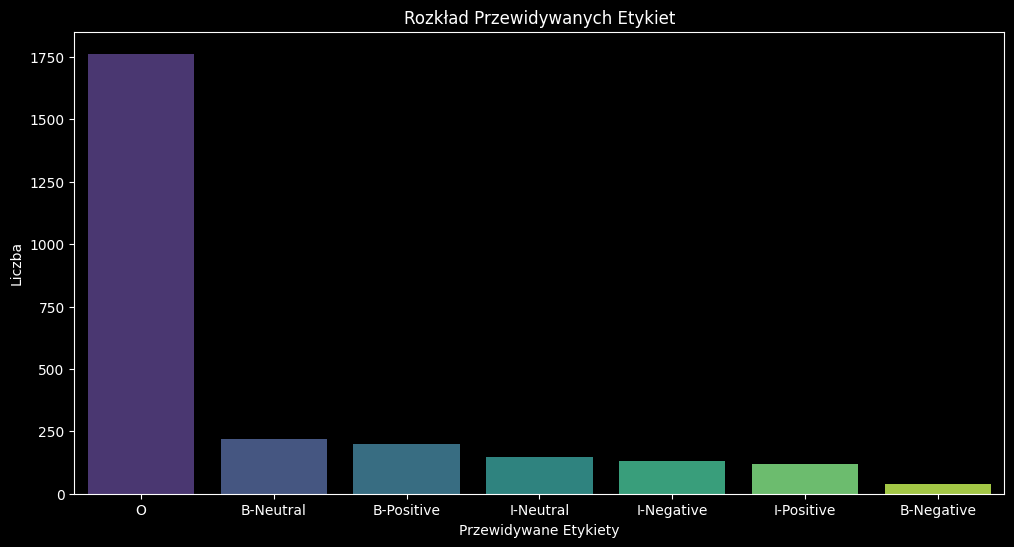

In [22]:
pred_label_counts = pd.Series(predicted_labels).value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=pred_label_counts.index, y=pred_label_counts.values, hue=pred_label_counts.index, palette='viridis')
plt.xlabel('Przewidywane Etykiety')
plt.ylabel('Liczba')
plt.title('Rozkład Przewidywanych Etykiet')
plt.show()

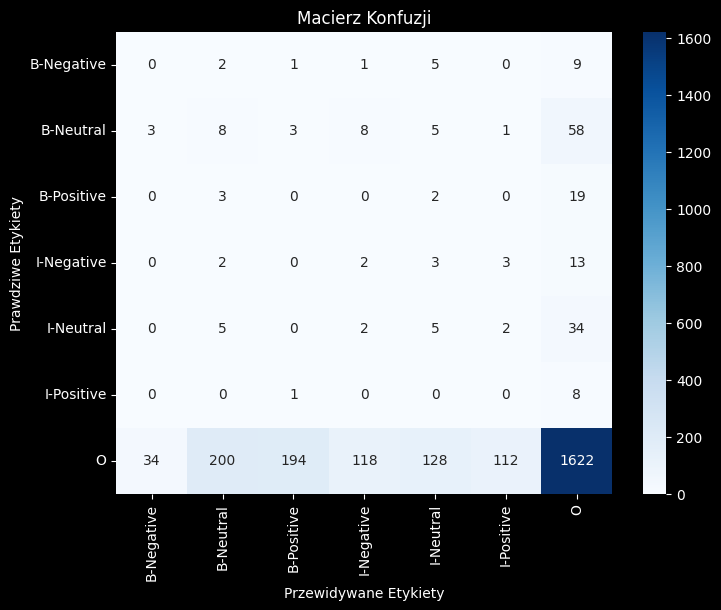

In [23]:
sorted_labels = sorted(label_list)

cm = confusion_matrix(true_labels, predicted_labels, labels=sorted_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted_labels, yticklabels=sorted_labels, cmap='Blues')
plt.xlabel('Przewidywane Etykiety')
plt.ylabel('Prawdziwe Etykiety')
plt.title('Macierz Konfuzji')
plt.show()

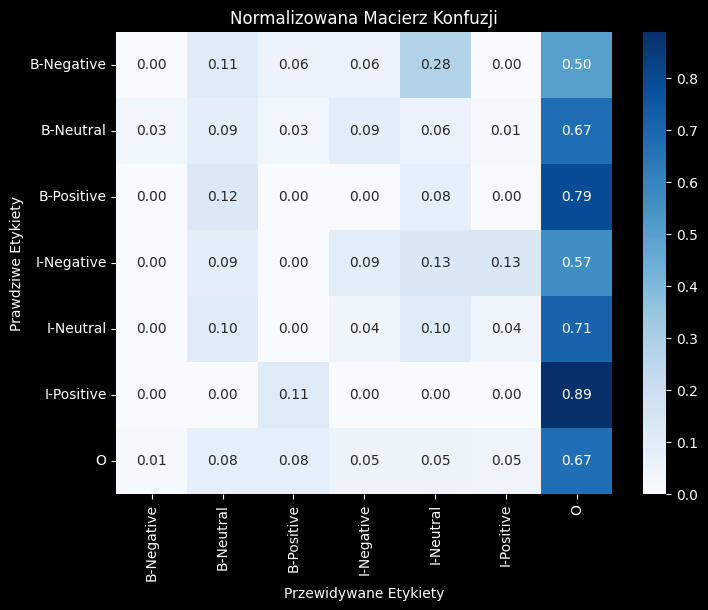

In [24]:
cm_normalized = confusion_matrix(true_labels, predicted_labels, labels=sorted_labels, normalize='true')

plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=sorted_labels, yticklabels=sorted_labels, cmap='Blues')
plt.xlabel('Przewidywane Etykiety')
plt.ylabel('Prawdziwe Etykiety')
plt.title('Normalizowana Macierz Konfuzji')
plt.show()

In [25]:
report = classification_report(true_labels, predicted_labels, target_names=sorted_labels)
print(report)


              precision    recall  f1-score   support

  B-Negative       0.00      0.00      0.00        18
   B-Neutral       0.04      0.09      0.05        86
  B-Positive       0.00      0.00      0.00        24
  I-Negative       0.02      0.09      0.03        23
   I-Neutral       0.03      0.10      0.05        48
  I-Positive       0.00      0.00      0.00         9
           O       0.92      0.67      0.78      2408

    accuracy                           0.63      2616
   macro avg       0.14      0.14      0.13      2616
weighted avg       0.85      0.63      0.72      2616

